# Deploy Clusters - High Value Customer Identification

In [1]:
import pandas as pd
import numpy as np
import re
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

from scipy.cluster import hierarchy as hc

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

import sqlite3
from sqlalchemy import create_engine

from umap.umap_ import UMAP

init_notebook_mode(connected=True)

D:\Anaconda\envs\insiders\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



# 0.0. Load dataset <a id='load_dataset'></a>

In [2]:
# root path
ROOT_PATH = os.path.dirname(os.path.abspath('.'))

# load data
df_raw = pd.read_csv(f'{ROOT_PATH}/data/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw.drop(df_raw.columns[len(df_raw.columns)-1], axis=1, inplace=True)

In [3]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0. Data Description <a id='data_description'></a>

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns <a id='rename_columns'></a>

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions <a id='data_dimensions'></a>

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types <a id='data_types'></a>

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check Missing Values <a id='check_na'></a>

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fill Missing Values <a id='fill_na'></a>

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]
df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [10]:
# create reference for customer_id
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge original data with reference dataframe
df1 = df1.merge(df_backup, on = 'invoice_no', how = 'left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change DTypes <a id='change_dtypes'></a>

In [12]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7. Descriptive Statistical <a id='descriptive_statistical'></a>

In [14]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes <a id='numerical_attributes'></a>

In [15]:
num = num_attributes.describe().T
num['skew'] = num_attributes.apply(lambda x: x.skew())
num['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())
num

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0,-0.264076,119769.160031
unit_price,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0,186.506972,59005.719097


### 1.7.2. Categorical Attributes <a id='categorical_attributes'></a>

#### Invoice No

In [16]:
cat_attributes.head()

,invoice_no,stock_code,description,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom,17850


In [17]:
# number of invoice_no that has letters inside it
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :].drop_duplicates()
print(f'Number of distinct invoice_no that has letter in it: {len(df_letter_invoices.invoice_no.unique())}')
print(f'Number of total invoice_no that has letter in it: {len(df_letter_invoices)}')
n = len(df_letter_invoices.loc[df_letter_invoices['quantity'] < 0])
print(f'Number of invoice_no that has letter in it and quantity is less than 0: {n}')
df_letter_invoices.head()

Number of distinct invoice_no that has letter in it: 3839
Number of total invoice_no that has letter in it: 9254
Number of invoice_no that has letter in it and quantity is less than 0: 9251


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548


#### Stock Code

In [18]:
# number of stock_code that has letters inside it
aux = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), :].drop_duplicates()
print(len(aux.stock_code.unique()))
aux.head()

1124


,invoice_no,stock_code,description,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom,17850
45,536370,POST,POSTAGE,France,12583


In [19]:
# number of stock_code that has ONLY letters inside it
aux = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].drop_duplicates()
print(len(aux.stock_code.unique()))
aux.head()

12


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001


In [20]:
# distinct stock_code with only letters
aux['stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country

In [21]:
# countries in dataset
len(df1['country'].unique())

38

In [22]:
# check purchase's volumetry
df1['country'].value_counts(normalize = True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [23]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2.0. Data Filtering <a id='data_filtering'></a>

In [24]:
df2 = df1.copy()

In [25]:
df2.loc[df2['unit_price'] > 0.001, ['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending = True).head(10)

,customer_id,description,unit_price
108088,16422,Discount,0.01
355050,16422,Manual,0.03
4287,15838,ROTATING SILVER ANGELS T-LIGHT HLDR,0.03
182729,12901,Discount,0.03
325477,12627,POPART WOODEN PENCILS ASST,0.04
427893,13822,POPART WOODEN PENCILS ASST,0.04
344823,14124,POPART WOODEN PENCILS ASST,0.04
228959,14282,POPART WOODEN PENCILS ASST,0.04
400464,12474,POPART WOODEN PENCILS ASST,0.04
269871,13081,POPART WOODEN PENCILS ASST,0.04


In [26]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock code != 'POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# country
df2 = df2[~df2['country'].isin(['Unspecified', 'European Community'])]

# description
df2.drop(columns = 'description', inplace = True)

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity - Negative numbers means devolution
df2_returns = df2.loc[df2['quantity'] < 0, :].copy()
df2_purchases = df2.loc[df2['quantity'] > 0, :].copy()

# 3.0. Feature Engineering <a id='feature_engineering'></a>

In [27]:
df3 = df2.copy()

## 3.1. Feature Creation <a id='feature_creation'></a>

In [28]:
# data reference
df_ref = df3.drop(columns = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country']) \
            .drop_duplicates(ignore_index = True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 3.1.1. Gross Revenue <a id='gross_revenue'></a>

In [29]:
# Gross Revenue = quantity * price
df2_purchases['gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = df_ref.merge(df_monetary, how = 'left', on = 'customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Last Purchase <a id='recency'></a>

In [30]:
# Recency - Last day purchase
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = df_ref.merge(df_recency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Total Products Purchased <a id='total_products_purchased'></a>

In [31]:
# Total Products Purchases
df_freq = df2_purchases[['customer_id', 'stock_code']].groupby('customer_id') \
                                                      .count() \
                                                      .reset_index() \
                                                      .rename(columns = {'stock_code' : 'total_products'})
df_ref = df_ref.merge(df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_products    91
dtype: int64

### 3.1.4. Frequency Purchase  <a id='frequency_purchase'></a>

In [32]:
df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
df2_purchase = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count()

In [33]:
df_aux = df2_purchases[['invoice_no', 'customer_id', 'invoice_date']].drop_duplicates() \
                                                                     .groupby('customer_id') \
                                                                     .agg(max_ = ('invoice_date', 'max'),
                                                                          min_ = ('invoice_date', 'min'),
                                                                          days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                          buy_ = ('invoice_no', 'count')).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)

# Merge
df_ref = df_ref.merge(df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_products    91
frequency         91
dtype: int64

### 3.1.5. Returns  <a id='returns'></a>

In [34]:
# Number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns = {'quantity' : 'returns'})
df_returns['returns'] = df_returns['returns'] * -1
df_ref = df_ref.merge(df_returns, on = 'customer_id', how = 'left')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_products    91
frequency         91
returns            0
dtype: int64

# 4.0. EDA (Exploratory Data Analysis) <a id='eda'></a>

In [35]:
df4 = df_ref.dropna().copy()

In [36]:
df4.shape

(5695, 6)

## 4.3. Spatial Study <a id='spatial_study'></a>

In [37]:
# filtered dataset
cols_selected = ['gross_revenue', 'recency_days', 'total_products', 'frequency', 'returns']
df43 = df4[cols_selected].copy()

In [38]:
# scaling
mm = MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
df43['total_products'] = mm.fit_transform(df43[['total_products']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['returns'] = mm.fit_transform(df43[['returns']])

In [39]:
X = df43.copy()

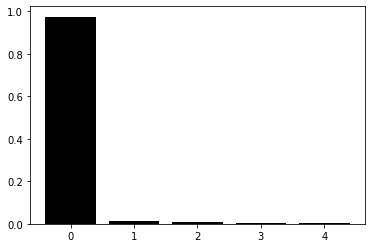

In [40]:
pca = PCA(n_components = X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color = 'black');

# pca components to dataframe
df_pca = pd.DataFrame(principal_components)

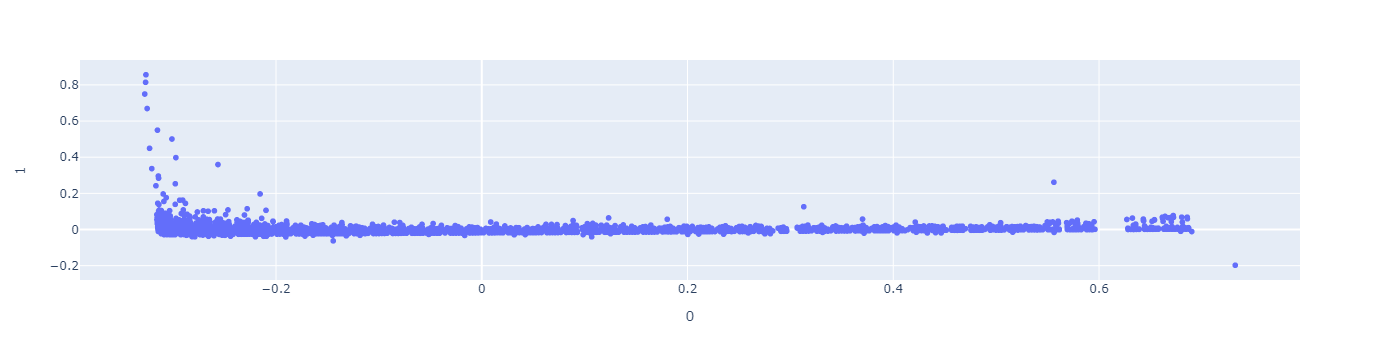

In [41]:
fig = px.scatter(df_pca, x = 0, y = 1)
fig.show()

## 4.3.1. Tree-Based Embedding <a id='tsne'></a>

In [42]:
# training dataset
X = df43.drop(columns = ['gross_revenue'], axis = 1)
y = df43['gross_revenue']

# model definition
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# model training
rf.fit(X, y)

# leafs
df_leaf = pd.DataFrame(rf.apply(X))
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6432,6889,6929,6404,6584,6824,6851,6937,6952,6502,...,6922,6519,7006,6720,6704,6645,6494,6536,6565,6836
1,6402,6189,6371,6314,6369,6551,6342,5646,6861,6316,...,6335,6293,6886,6325,6201,6205,6325,6404,6404,6531
2,5392,6459,6832,6393,6530,6767,6310,6827,6821,6914,...,6435,6405,6906,5705,6302,6582,6449,6374,6561,6775
3,2788,498,888,545,412,630,832,511,927,679,...,1234,697,857,539,962,726,632,1085,541,339
4,527,210,512,842,595,1684,501,967,1321,471,...,411,953,456,782,530,74,541,92,688,1557


D:\Anaconda\envs\insiders\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



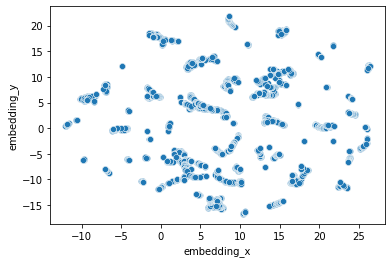

In [43]:
# umap on leaves
embedding = UMAP(random_state = 42).fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', 
                y = 'embedding_y',
                data = df_tree);

# 5.0. Hyperparameter Fine-Tunning <a id='hyperparameter'></a>

In [44]:
X = df_tree.copy()

# 6.0. Model Training <a id='model_training'></a>

## 6.1. K-Means <a id='kmeans'></a>

In [45]:
# model definition
k = 8
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 6.2. Cluster Validation <a id='cluster_validation'></a>

In [46]:
# WSS (Within-cluster sum of squares)
print(f'WSS Value: {kmeans.inertia_}')

# SS (Silhouette Score)
print(f'SS Value: {silhouette_score(X, labels, metric = "euclidean")}')

WSS Value: 119637.8046875
SS Value: 0.43060919642448425


# 7.0. Cluster Analysis <a id='cluster_analysis'></a>

In [47]:
df92 = df4.copy()
df92['cluster'] = labels

df92['recency_days'] = df92['recency_days'].astype(int)
df92['total_products'] = df92['total_products'].astype(int)
df92['returns'] = df92['returns'].astype(int)

df92.head()

,customer_id,gross_revenue,recency_days,total_products,frequency,returns,cluster
0,17850,5391.21,372,297,17.000000,40,5
1,13047,3232.59,56,171,0.028302,35,5
2,12583,6705.38,2,232,0.040323,50,5
3,13748,948.25,95,28,0.017921,0,7
4,15100,876.00,333,3,0.073171,22,7


In [48]:
# Number of customers
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_gross_revenue, how = 'inner', on = 'cluster')

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_recency_days, how = 'inner', on = 'cluster')

# Avg total_products
df_total_products = df92[['total_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_total_products, how = 'inner', on = 'cluster')

# Avg frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_frequency, how = 'inner', on = 'cluster')

# Avg returns
df_returns = df92[['returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_returns, how = 'inner', on = 'cluster')

df_cluster.sort_values(by = 'gross_revenue', ascending = False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,total_products,frequency,returns
0,0,595,10.447761,6316.072824,75.517647,293.833613,0.274207,231.477311
5,5,867,15.223881,2686.738985,91.723183,168.610150,0.366643,23.935409
7,7,465,8.165057,1875.685871,86.529032,47.122581,0.244613,13.311828
3,3,998,17.524144,1824.752685,97.438878,121.535070,0.493835,2.567134
2,2,506,8.884987,1061.656976,103.169960,50.816206,0.342350,7.213439
1,1,644,11.308165,492.556615,118.065217,17.465839,0.400194,2.624224
4,4,436,7.655838,383.362041,208.536697,25.745413,0.972605,0.481651
6,6,1184,20.790167,255.358505,156.086149,12.673142,0.991740,4.467905


#### Cluster names

* Cluster 0: Insiders
* Cluster 5: Buy More Products
* Cluster 7: Spend More Money
* Cluster 3: Buy Even More Products
* Cluster 2: Less Days
* Cluster 1: Less 1k
* Cluster 4: Minimun Products
* Cluster 6: Stop Returning

# 11.0. Deploy to Production <a id='deploy'></a>

## 11.1. Local Deploy <a id='local_deploy'></a>

<center><img src="../img/deploy_local.png" width="1000"/></center>

In [49]:
df92.dtypes

customer_id         int32
gross_revenue     float64
recency_days        int32
total_products      int32
frequency         float64
returns             int32
cluster             int32
dtype: object

## 11.2. Insert into SQLite <a id='insert_sqlite'></a>

In [50]:
def create_database(query, database):
    if not os.path.exists(database):
        conn = sqlite3.connect(database)
        conn.execute(query)
        conn.commit()
        conn.close()

def insert_data(dataframe, database, tablename):
    conn = create_engine(f'sqlite:///{database}')
    dataframe.to_sql(tablename, conn, if_exists = 'replace', index = False)
    
def consult_database(query, database):
    conn = create_engine(f'sqlite:///{database}')
    df = pd.read_sql_query(query, conn)
    
    return df

In [51]:
database = f'{ROOT_PATH}/database/db_insiders.sqlite'

# create table
query_create_table_insiders = """
CREATE TABLE insiders (
    customer_id         INTEGER,
    gross_revenue       REAL,
    recency_days        INTEGER,
    total_products      INTEGER,
    frequency           REAL,
    returns             INTEGER,
    cluster             INTEGER
)
"""

create_database(query_create_table_insiders, database)

# insert data
insert_data(df92, database, 'insiders')

# select data
query = """
SELECT * FROM insiders
"""

df = consult_database(query, database)
df.head()

,customer_id,gross_revenue,recency_days,total_products,frequency,returns,cluster
0,17850,5391.21,372,297,17.000000,40,5
1,13047,3232.59,56,171,0.028302,35,5
2,12583,6705.38,2,232,0.040323,50,5
3,13748,948.25,95,28,0.017921,0,7
4,15100,876.00,333,3,0.073171,22,7
